In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import torch
import torch.nn as nn
import anomaly_tpp as tpp

from tqdm.auto import tqdm, trange
from statsmodels.distributions.empirical_distribution import ECDF

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
t_max = 100
num_sequences = 1000
batch_size = 64

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [3]:
# scenario = tpp.scenarios.multivariate.ServerStop(t_max, num_sequences)
scenario = tpp.scenarios.multivariate.ServerOverload(t_max, num_sequences)
# scenario = tpp.scenarios.multivariate.Latency(t_max, num_sequences)
# scenario = tpp.scenarios.multivariate.Connectome()

In [4]:
id_train = scenario.get_id_train()
dl_train = id_train.get_dataloader(batch_size=batch_size, shuffle=True)

In [5]:
# Fit a neural TPP model on the training ID sequences
ntpp = tpp.utils.fit_ntpp_model(dl_train, num_marks=id_train.num_marks)

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 53


In [6]:
test_statistics = [
    tpp.statistics.ks_arrival,
    tpp.statistics.ks_interevent,
    tpp.statistics.chi_squared,
    tpp.statistics.sum_of_squared_spacings,
    tpp.statistics.loglike,
]

### Estimate distribution of each test statistic under $H_0$

In [7]:
# in-distribution (ID) training sequences are used to estimate the CDF of the test statistic under H_0
# (this is then used to compute the p-values)
id_train_batch = tpp.data.Batch.from_list(id_train)
id_train_poisson_times = tpp.utils.extract_poisson_arrival_times(ntpp, id_train_batch)

In [8]:
# Empirical distribution of each test statistic on id_train.
# This approximates the CDF of the test statistic under H_0
# and is used to compute the p-values
ecdfs = {}

for stat in test_statistics:
    name = stat.__name__
    scores = stat(poisson_times_per_mark=id_train_poisson_times, model=ntpp, batch=id_train_batch)
    ecdfs[name] = ECDF(scores)

def twosided_pval(stat_name: str, scores: np.ndarray):
    """Compute two-sided p-value for the given values of test statistic.
    
    Args:
        stat_name: Name of the test statistic, 
            {"ks_arrival", "ks_interevent", "chi_squared", "sum_of_squared_spacings"}
        scores: Value of the statistic for each sample in the test set,
            shape [num_test_samples]
    
    Returns:
        p_vals: Two-sided p-value for each sample in the test set,
            shape [num_test_samples]
    """
    ecdf = ecdfs[stat_name](scores)
    return 2 * np.minimum(ecdf, 1 - ecdf)

### Compute test statistic for ID test sequences

In [9]:
# ID test sequences will be compared to OOD test sequences to evaluate different test statistics
id_test = scenario.get_id_test()
id_test_batch = tpp.data.Batch.from_list(id_test)
id_test_poisson_times = tpp.utils.extract_poisson_arrival_times(ntpp, id_test_batch)

# Compute the statistics for all ID test sequences
id_test_scores = {}
for stat in test_statistics:
    name = stat.__name__
    id_test_scores[name] = stat(poisson_times_per_mark=id_test_poisson_times, model=ntpp, batch=id_test_batch)

### Compute test statistic for OOD test sequences & evaluate AUC ROC based on the p-values

In [10]:
ntpp.cuda()
results = []
detectability_values = np.arange(0, 0.95, step=0.05)
num_seeds = 5

for seed in trange(num_seeds):
    for det in tqdm(detectability_values):
        np.random.seed(seed)
        ood_test = scenario.sample_ood(detectability=det, seed=seed)
        ood_test_batch = tpp.data.Batch.from_list(ood_test).cuda()
        ood_test_poisson_times = tpp.utils.extract_poisson_arrival_times(ntpp, ood_test_batch)

        for stat in test_statistics:
            stat_name = stat.__name__
            id_scores = id_test_scores[stat_name]
            id_pvals = twosided_pval(stat_name, id_scores)

            ood_scores = stat(poisson_times_per_mark=ood_test_poisson_times, model=ntpp, batch=ood_test_batch)
            ood_pvals = twosided_pval(stat_name, ood_scores)

            auc = tpp.utils.roc_auc_from_pvals(id_pvals, ood_pvals)

            res = {"statistic": stat_name, "seed": seed, "detectability": det, 
                   "auc": auc, "scenario": scenario.name}
            results.append(res)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [11]:
df = pd.DataFrame(results)

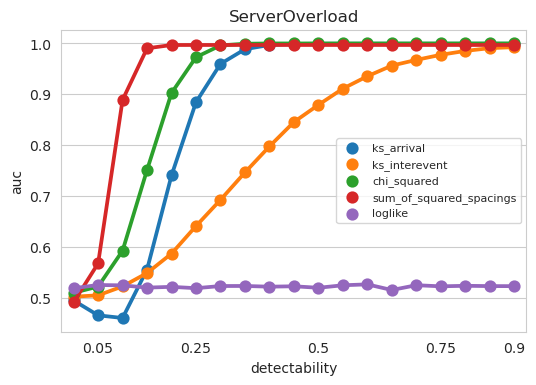

In [12]:
plt.figure(dpi=100)
sns.pointplot(data=df, x="detectability", y="auc", hue="statistic", ci=None)
ax = plt.gca()
ax.set_xticks([1, 5, 10, 15, 18])
ax.set_title(scenario.name)
plt.legend(fontsize=8)
plt.show()